$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 5: Convolutional Architecture Experiments
<a id=part5></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll use our deep CNN implementation and perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Experimenting with model architectures
<a id=part5_3></a>

We will now perform a series of experiments that train various model configurations on a part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### Note about running on GPUs

Here's an example of running a forward pass on the GPU
(assuming you're running this notebook on a GPU-enabled machine).

In [3]:
from hw2.cnn import ResNet

net = ResNet(
    in_size=(3,100,100), out_classes=10, channels=[32, 64]*3,
    pool_every=4, hidden_dims=[100]*2,
    pooling_type='avg', pooling_params=dict(kernel_size=2),
)
net = net.to(device)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_image = test_image.to(device)

test_out = net(test_image)

Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [4]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are also on device={next(net.parameters()).device}')
print(f'The test image is also on device={test_image.device}')
print(f'The output is therefore also on device={test_out.device}')

This notebook is running with device=cpu
The model parameter tensors are also on device=cpu
The test image is also on device=cpu
The output is therefore also on device=cpu


### Notes on using course servers

First, please read the [course servers guide](https://vistalab-technion.github.io/cs236781/assignments/hpc-servers) carefully.

To run the experiments on the course servers, you can use the `py-sbatch.sh` script directly to perform a single experiment run in batch mode (since it runs python once), or use the `srun` command to do a single run in interactive mode. For example, running a single run of experiment 1 interactively (after `conda activate` of course):

```shell
srun -c 2 --gres=gpu:1 --pty python -m hw2.experiments run-exp -n test -K 32 64 -L 2 -P 2 -H 100
```

To perform multiple runs in batch mode with `sbatch` (e.g. for running all the configurations of an experiments), you can create your own script based on `py-sbatch.sh` and invoke whatever commands you need within it.

Don't request more than **2 CPU** cores and **1 GPU** device for your runs. The code won't be able to utilize more than that anyway, so you'll see no performance gain if you do. It will only cause delays for other students using the servers.

### General notes for running experiments

- You can run the experiments on a different machine (e.g. the course servers) and copy the results (files)
  to the `results` folder on your local machine.
  This notebook will only display the results, not run the actual experiment code (except for a demo run).
- It's important to give each experiment run a name as specified by the notebook instructions later on.
  Each run has a `run_name` parameter that will also be the base name of the results file which this 
  notebook will expect to load.
- You will implement the code to run the experiments in the `hw2/experiments.py` module.
  This module has a CLI parser so that you can invoke it as a script and pass in all the
  configuration parameters for a single experiment run.
- You should use `python -m hw2.experiments run-exp` to run an experiment, and **not**
  `python hw2/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1: Network depth and number of filters

In this part we will test some different architecture configurations based on our `CNN` and `ResNet`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. If we also use `pool_every=3`, the feature-extraction part of our model will be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->Conv(32,64)->ReLU->MaxPool->Conv(64,64)->ReLU
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pool_every` and `hidden_dims`. Note that you should select the `pool_every` parameter wisely per experiment so that you don't end up with zero-width feature maps.

You can try some short manual runs to determine some good values for the hyperparameters or implement cross-validation to do it. However, the **dataset size** you test on should be large. If you limit the number of batches, make sure to use at least 30000 training images and 5000 validation images.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `cnn_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified
Files already downloaded and verified
--- EPOCH 1/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/1000 [00:00<?, ?it/s]

test_batch:   0%|          | 0/834 [00:00<?, ?it/s]

*** Output file ./results/test_run_L1_K32-64.json written
experiment config:  {'run_name': 'test_run', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'filters_per_layer': [32, 64], 'pool_every': 1, 'hidden_dims': [100], 'model_type': 'resnet', 'activation_type': 'relu', 'activation_params': {}, 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'pooling_params': {'kernel_size': 2}, 'pooling_type': 'max', 'batchnorm': True, 'dropout': 0.2, 'bottleneck': False, 'kw': {}, 'layers_per_block': 1}


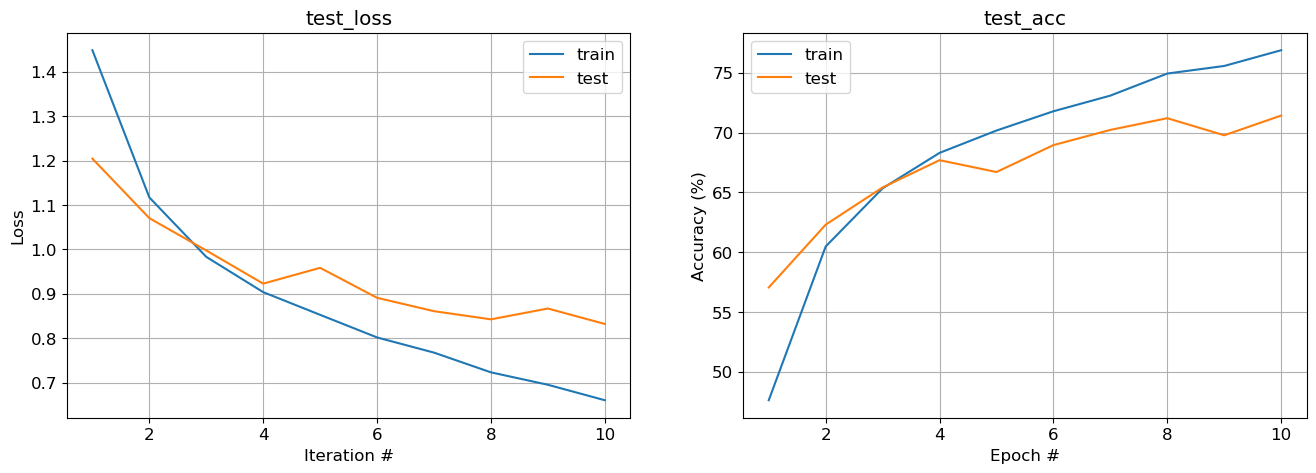

In [5]:
from hw2.experiments import load_experiment, cnn_experiment
from cs236781.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
cnn_experiment(
    'test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
    filters_per_layer=[32,64], layers_per_block=1, pool_every=1, hidden_dims=[100],
    model_type='resnet',
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run_L1_K32-64.json')
_, _ = plot_fit(fit_res, train_test_overlay=True)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

We'll use the following function to load multiple experiment results and plot them together.

In [6]:
from hw2.experiments import load_experiment, cnn_experiment
from cs236781.plot import plot_fit
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_1', 'out_dir': '/home/yonathanw/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 64, 'bs_test': 64, 'batches': 1500, 'epochs': 20, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'activation_type': 'relu', 'activation_params': {}, 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'pooling_params': {'kernel_size': 2}, 'pooling_type': 'max', 'batchnorm': True, 'dropout': 0.2, 'bottleneck': False, 'momentum': 0.99, 'kw': {}}


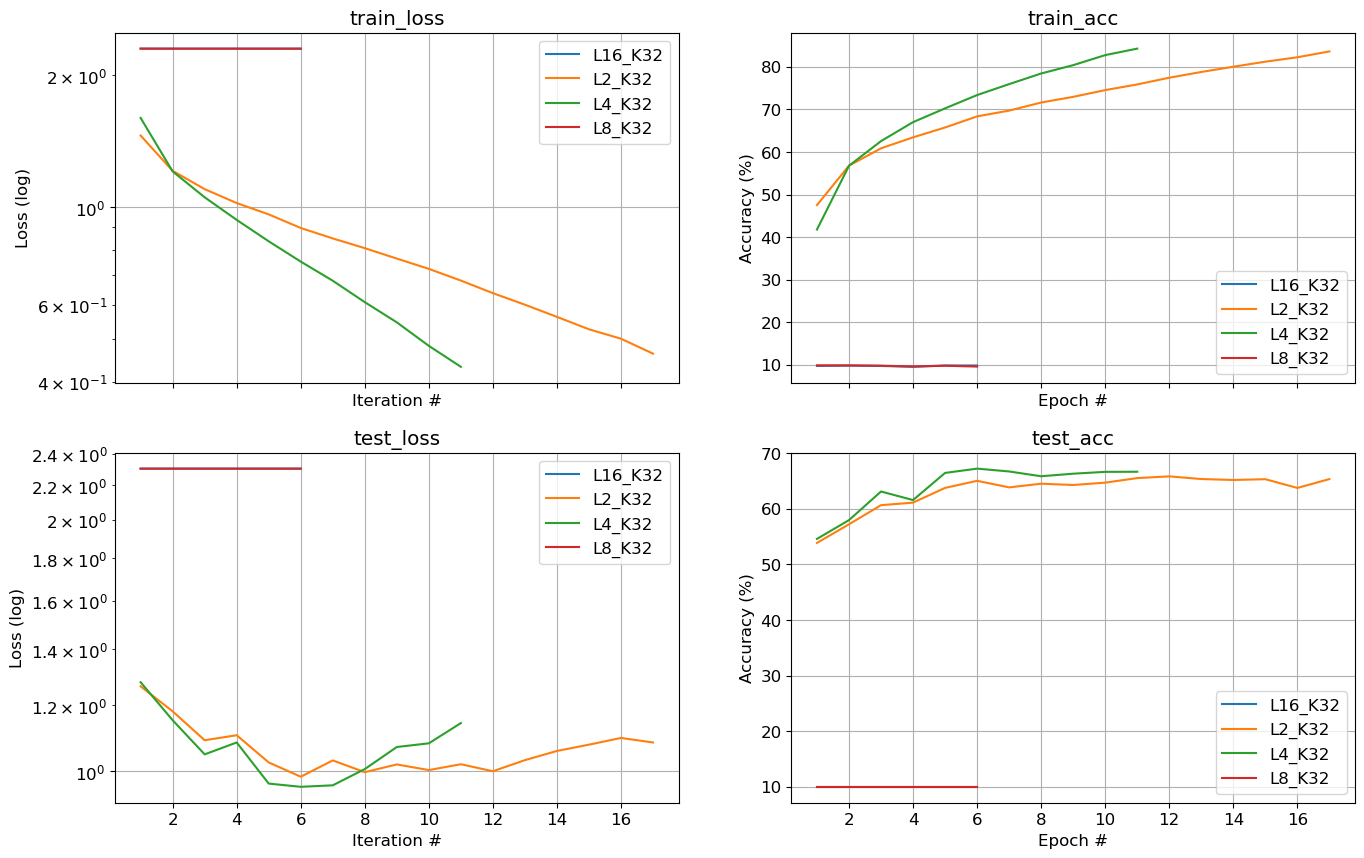

In [7]:
plot_exp_results('exp1_1_L*_K32*.json')

common config:  {'run_name': 'exp1_1', 'out_dir': '/home/inbar.m/hw/deep_on_gpu_hw2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 30, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'activation_type': 'relu', 'activation_params': {}, 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'pooling_params': {'kernel_size': 2}, 'pooling_type': 'max', 'batchnorm': True, 'dropout': 0.0, 'bottleneck': False, 'kw': {}}


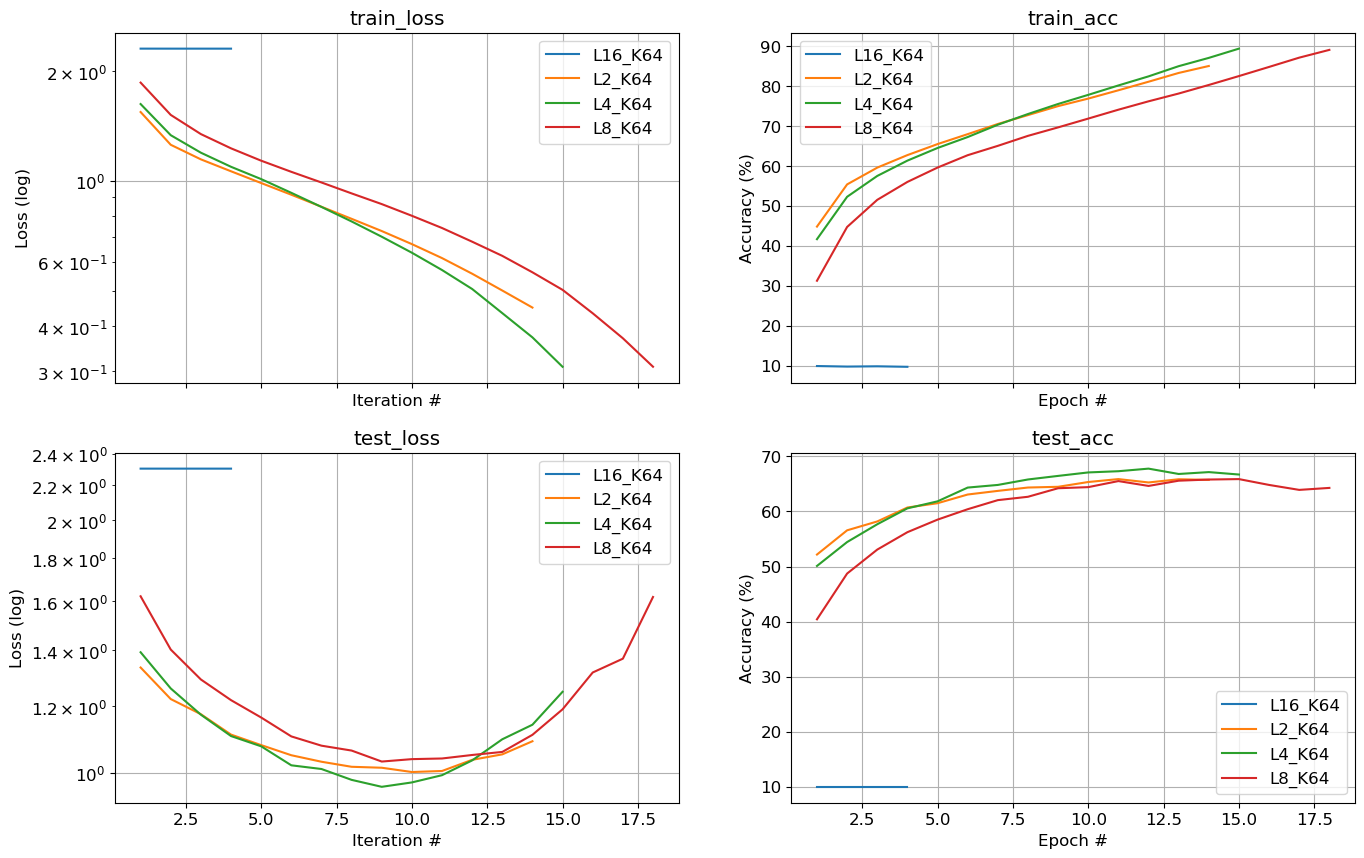

In [8]:
plot_exp_results('exp1_1_L*_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128]` varying per run.

So 9 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2', 'out_dir': '/home/yonathanw/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 64, 'bs_test': 64, 'batches': 1500, 'epochs': 20, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.002, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'activation_type': 'relu', 'activation_params': {}, 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'pooling_params': {'kernel_size': 2}, 'pooling_type': 'max', 'batchnorm': True, 'dropout': 0.2, 'bottleneck': False, 'momentum': 0.99, 'kw': {}}


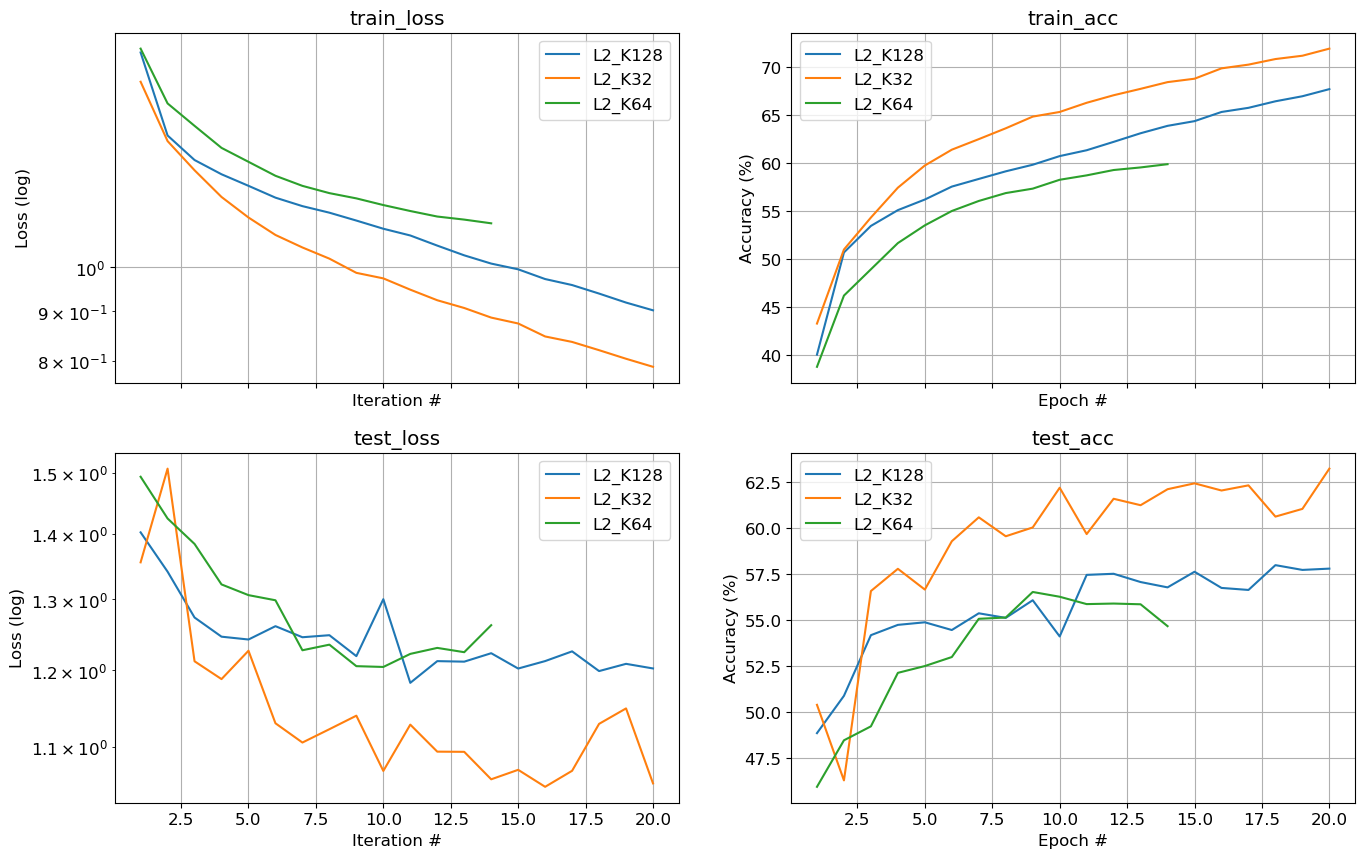

In [9]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': '/home/yonathanw/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 64, 'bs_test': 64, 'batches': 1500, 'epochs': 20, 'early_stopping': 2, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'activation_type': 'relu', 'activation_params': {}, 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'pooling_params': {'kernel_size': 2}, 'pooling_type': 'max', 'batchnorm': True, 'dropout': 0.2, 'bottleneck': False, 'momentum': 0.99, 'kw': {}}


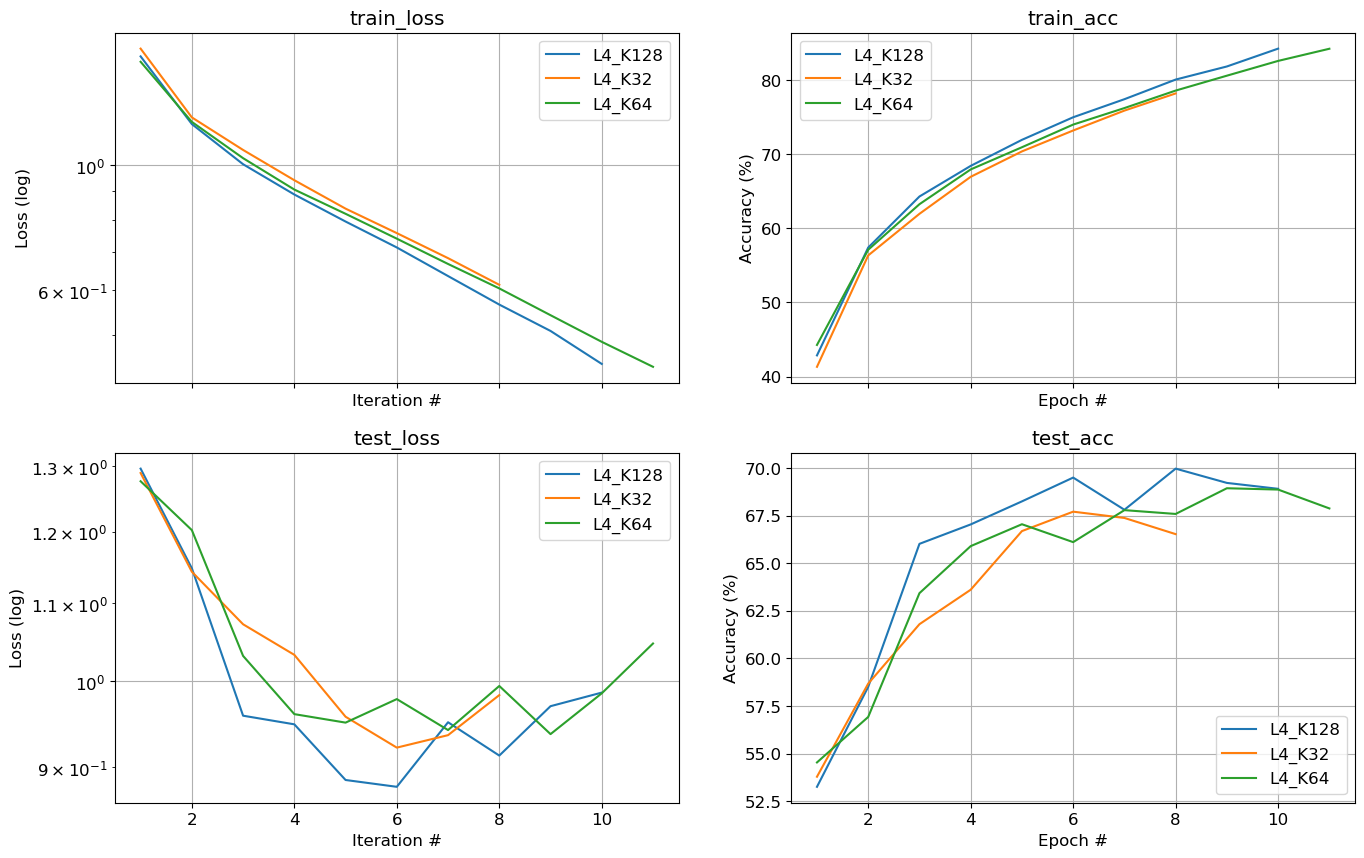

In [10]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': '/home/yonathanw/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 64, 'bs_test': 64, 'batches': 1500, 'epochs': 20, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.0004, 'reg': 0.0005, 'pool_every': 6, 'hidden_dims': [128], 'model_type': 'cnn', 'activation_type': 'relu', 'activation_params': {}, 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'pooling_params': {'kernel_size': 2}, 'pooling_type': 'max', 'batchnorm': True, 'dropout': 0.2, 'bottleneck': False, 'momentum': 0.99, 'kw': {}}


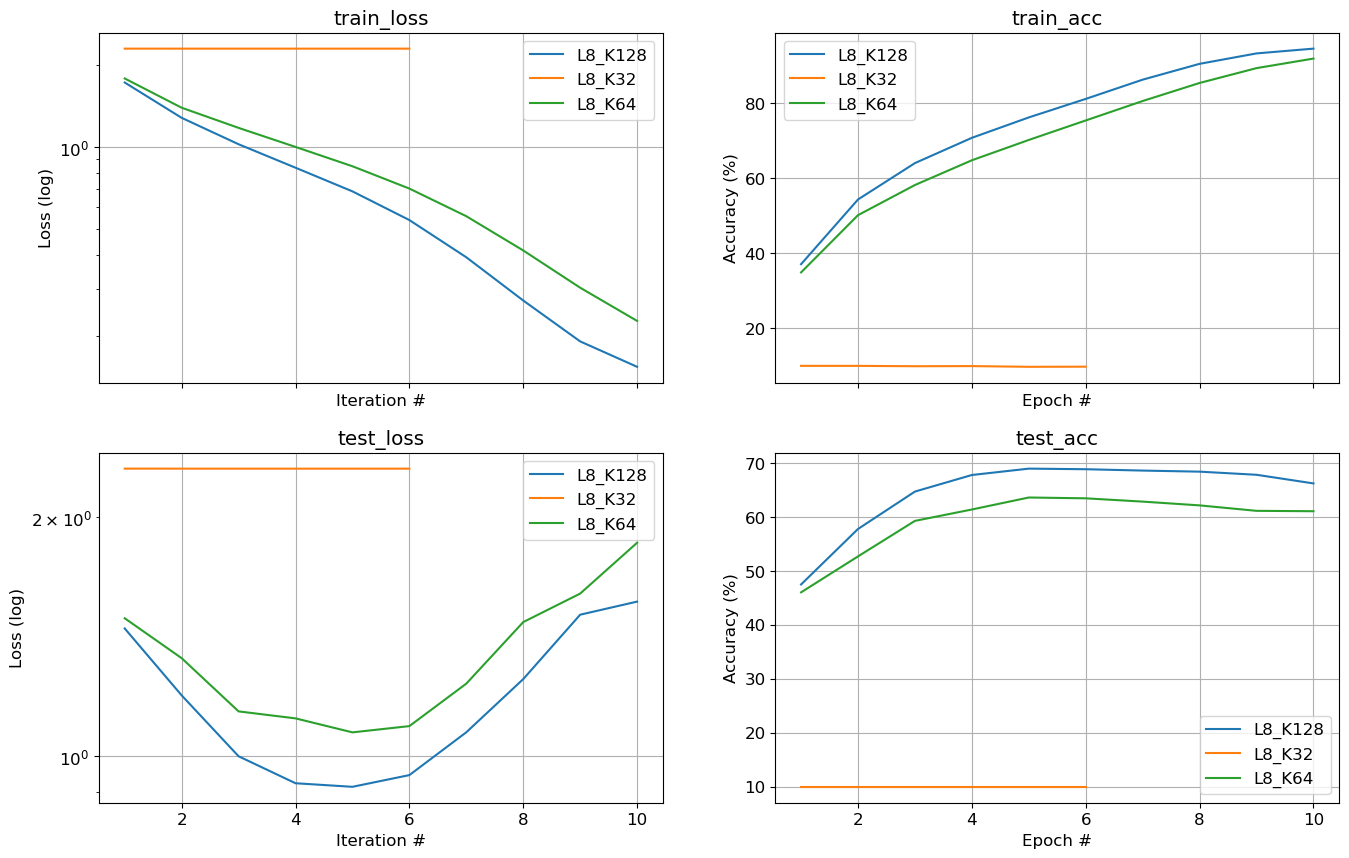

In [11]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128]` fixed with `L=2,3,4` varying per run.

So 3 different runs in total. To clarify, each run `K` takes the value of an array with a two elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L2_K64-128`. 

**TODO**: Run the experiment on the above configuration  with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3', 'out_dir': '/home/inbar.m/hw/deep_on_gpu_hw2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 30, 'early_stopping': 2, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'activation_type': 'relu', 'activation_params': {}, 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'pooling_params': {'kernel_size': 2}, 'pooling_type': 'max', 'batchnorm': True, 'dropout': '0.3', 'bottleneck': False, 'kw': {}}


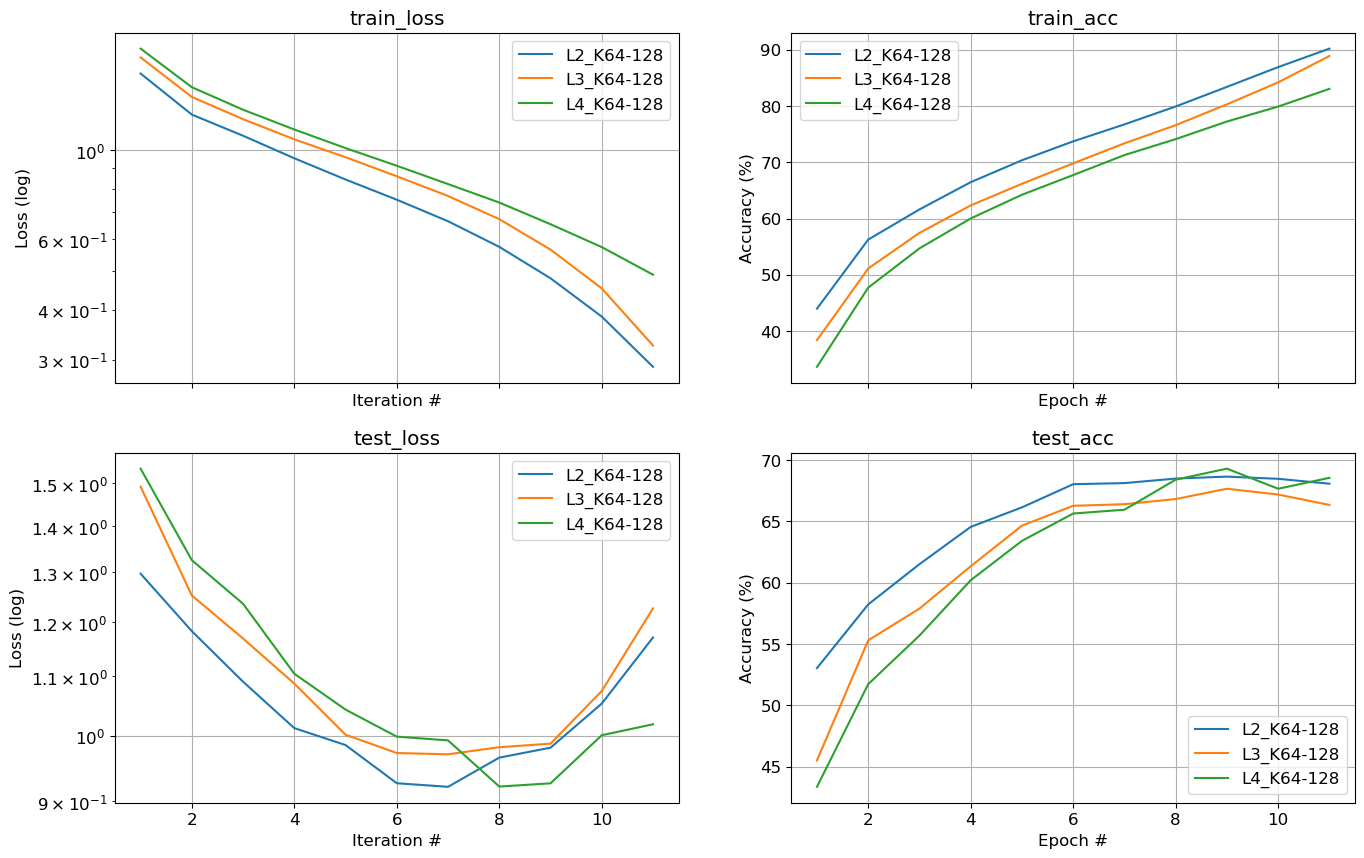

In [12]:
plot_exp_results('exp1_3*.json')

#### Experiment 1.4: Adding depth with Residual Networks

Now we'll test the effect of skip connections on the training and performance.

**Configuratons**:
- `K=[32]` fixed with `L=8,16,32` varying per run.
- `K=[64, 128, 256]` fixed with `L=2,4,8` varying per run.

So 6 different runs in total.

**Naming runs**:
Each run should be named `exp1_4_L{}_K{}-{}-{}` where the braces are placeholders for the values.

**TODO**: Run the experiment on the above configuration with the `ResNet` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_4', 'out_dir': '/home/inbar.m/hw/deep_on_gpu_hw2/results', 'seed': 42, 'device': None, 'bs_train': 64, 'bs_test': 64, 'batches': 1500, 'epochs': 30, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 8, 'hidden_dims': [512, 256], 'model_type': 'resnet', 'activation_type': 'relu', 'activation_params': {}, 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'pooling_params': {'kernel_size': 2}, 'pooling_type': 'max', 'batchnorm': True, 'dropout': 0.3, 'bottleneck': False, 'kw': {}}


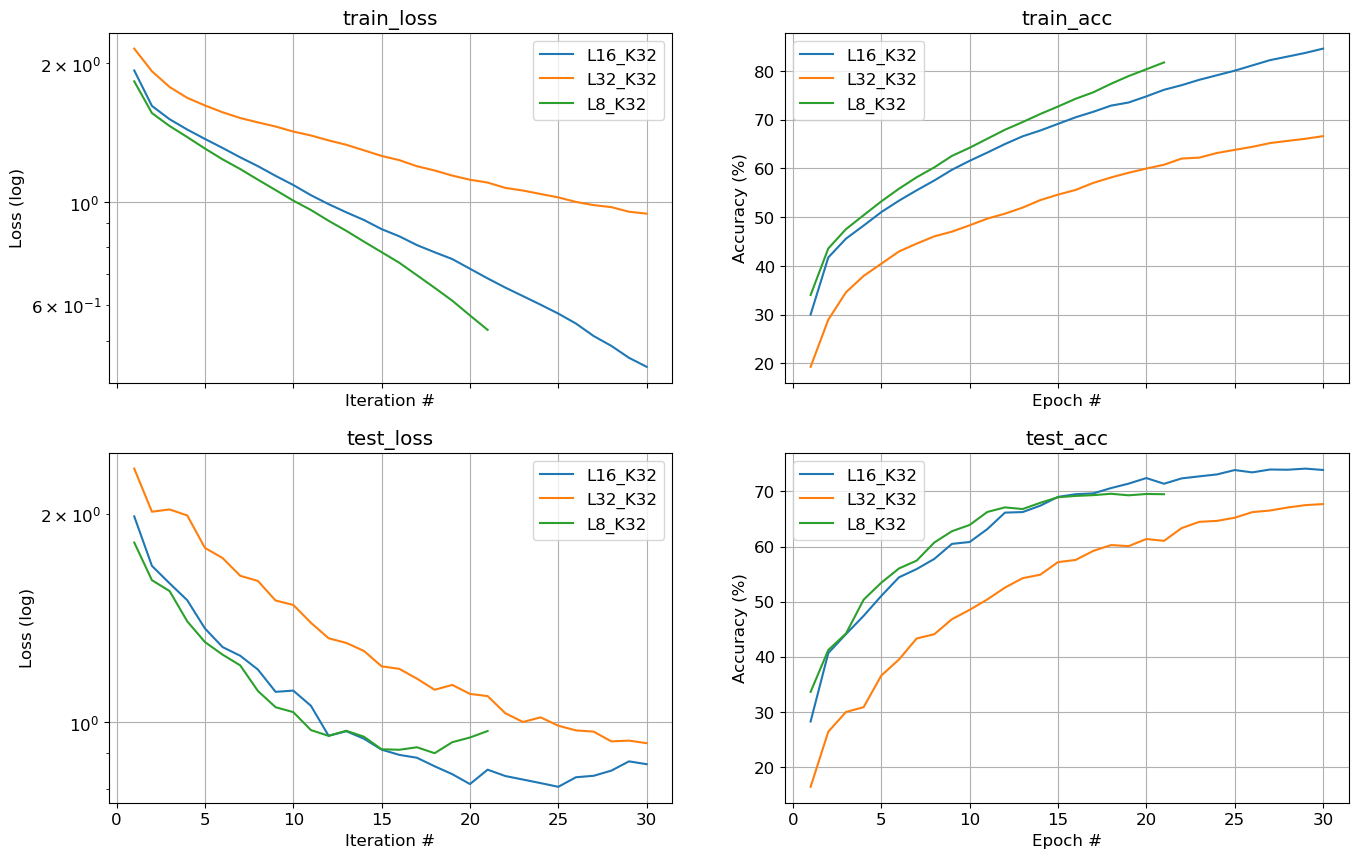

In [13]:
plot_exp_results('exp1_4_L*_K32.json')

common config:  {'run_name': 'exp1_4', 'out_dir': '/home/inbar.m/hw/deep_on_gpu_hw2/results', 'seed': 42, 'device': None, 'bs_train': 64, 'bs_test': 64, 'batches': 1500, 'epochs': 30, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 8, 'hidden_dims': [512, 256], 'model_type': 'resnet', 'activation_type': 'relu', 'activation_params': {}, 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'pooling_params': {'kernel_size': 2}, 'pooling_type': 'max', 'batchnorm': True, 'dropout': 0.3, 'bottleneck': False, 'kw': {}}


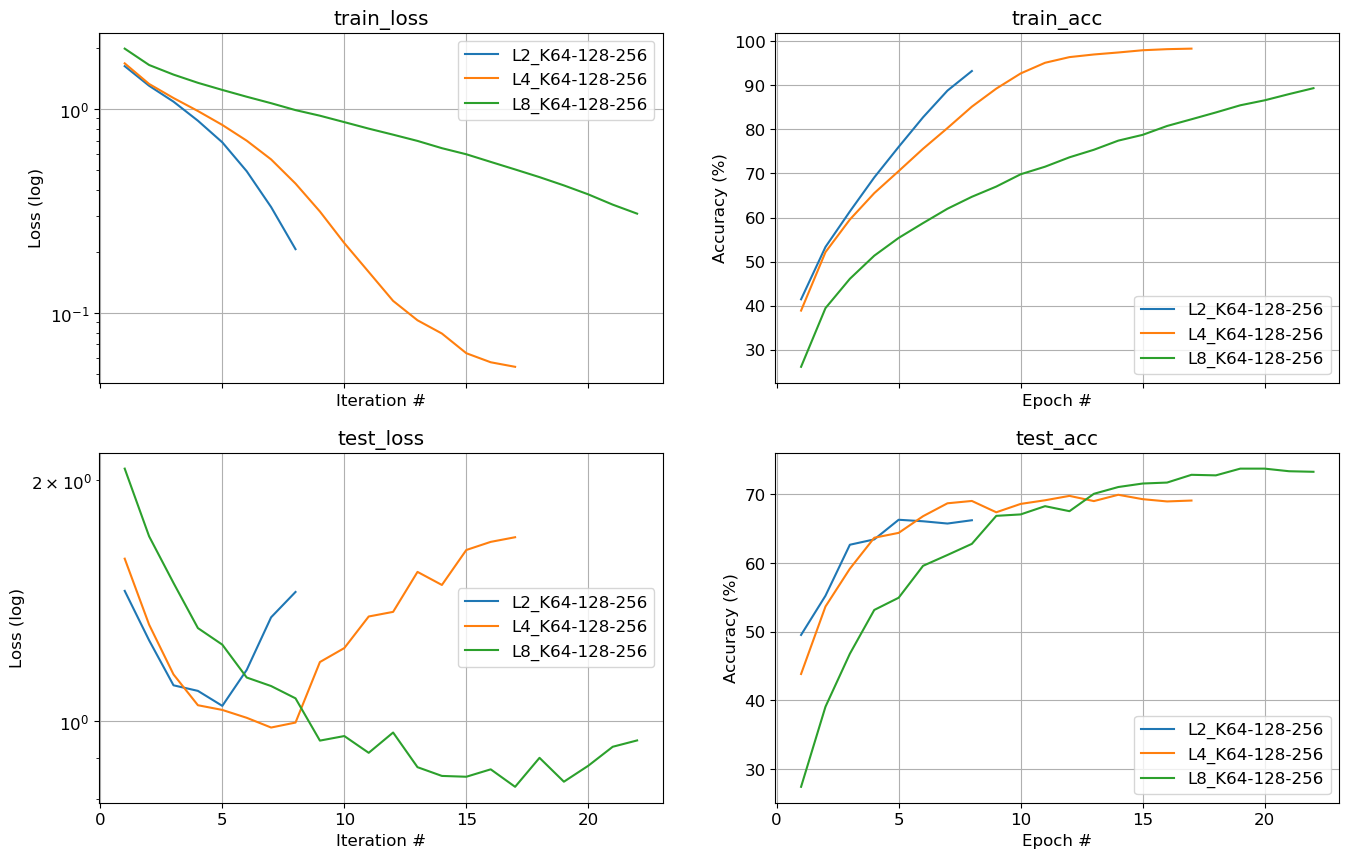

In [14]:
plot_exp_results('exp1_4_L*_K64*.json')

## Questions
<a id=part5_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [15]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [16]:
display_answer(hw2.answers.part5_q1)


In this experiment  we train diffrent models with different depth and kernel size. 
\\
Generally the results of experiment 1.1 were successful for L=2,4, in both cases we managed to get test accuracy of 65-70% for both k=32 and K=64. \\
1. We can see in our experiments that L=4 bring the best empirical results - both with K=32 and K=64. 
We can see in the graphs that both L=4 and L=2 learn the data and increase accuracy but in L=2 the test accuracy converges before the L=4 models, that may be due to its limitations, with small amount of layers the model is weaker and while able to learn, its limits are greater and that's probably why L=4 was able to increase accuracy for a longer time and to a better result.
On the other hand when the depth got larger - L=8,16 in the K=32 case and L=16 on the K=64 case, the models weren't able to learn at all, which we explain right below.
2. when L=8 or 16, the models weren't able to learn, this might have been due to the vanishing gradients problem - the more layers there are in the network, the more multiplications are done due to chain rule in order to calculate the gradient, and if some of the values in the way are small, the gradients will vanish and the model parameters will not move. There are some possible solutions for that issue, one can be batch normalization - it will tune the values of the parameters in order to stabilize the learning process and improve the gradient flow. We can also use residual networks, as we learned in class res nets try to solve this issue by creating shortcuts in order to strengthen the signal and avoid gradient vanishing in the backpropagaion process. We will show this solution in 1.4 and compare the results.


### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [17]:
display_answer(hw2.answers.part5_q2)


In experiments 1.2 we managed to train all models except of one (L=8, K=32). When L=2 we can see that the models were limited due to small amount of layers and didn't get very high result on training, generalization was fine and test accuracy of all 3 different K values were close to train accuracy in that case. In experiment 1.1. the limited abilities of L=2 were also visible and close. We can also see that large amount of filters per layer (large K) isn't helpful without enough layers. \
When L=4 and L=8 we see similar trends regarding K, we can see that with larger K the model is stronger and able to fit the training data better, but can also overfit, this is very clear in the test loss graphs that goes up after reaching good values, slightly after the test accuracy converged, even when using very small early_stopping value (in L=4) the test loss still managed to go up again before training stopped.
When comparing to experiments 1.1 we can see that bigger K makes the model stronger but can also lead to overfitting very quickly.


### Question 3 

Analyze your results from experiment 1.3.

In [18]:
display_answer(hw2.answers.part5_q3)


In experiments 1.3,all three runs achieved a training accuracy of 85-90% and a test accuracy of around 65-70%. Increasing dropout helped with generalization, preventing overfitting and improving test performance. \
However, even with early stopping, the test loss started to increase at some point, indicating that finding the right balance for early stopping is crucial to maintain test performance while avoiding a decrease in test accuracy.\
\\
Different filter sizes, such as [64, 128], provide varying capacities for feature extraction. Using two different K sizes means that the model can capture more varied and complex features, which can enhance its ability to generalize from the training data.
By comaring the plots of 1.1 in L=2,K=64 case and this plot, we can see the complexity introduced by having two different filter sizes per layer can help even shallower models capture more features, leading to higher training accuracy. \
When we tried using a higher weight decay in order to increase the generalization and test performance, models with L=4 layers struggled to learn and vanished. So, while L=4 is not considered very deep, it still requires a balanced approach to regularization.\
\\
With a fixed K, the models achieved approximately the same test accuracy, but training accuracy varied. The model with L=2 layers achieved the highest training accuracy, followed by L=3 and then L=4. 
In addition, deeper models like L=4, while potentially better at capturing complex patterns, face greater challenges during training without skip connections, which can result in lower training accuracy.
\\
In conclusion, increasing the number of layers while keeping the number of convolutional filters constant led to varying training dynamics, with dropout and early stopping playing critical roles in preventing overfitting. The chosen filter sizes provided a balanced capacity for feature extraction, and deeper models required more nuanced tuning of learning rate and regularization to balance effective learning and generalization.



### Question 4

Analyze your results from experiment 1.4. Compare to experiment 1.1 and 1.3.

In [19]:
display_answer(hw2.answers.part5_q4)


Experiment 1.4:\\
In this experiment, we tested the effect of skip connections using a ResNet architecture with six runs: \\

K=[32] fixed with L=8,16,32 \\

K=[64, 128, 256] fixed with L=2,4,8 \\

Results showed that with K=32, the models learned effectively and achieved around 70% test accuracy across different depths.
For K=[64, 128, 256], the depth had a significant impact. The model with L=2 struggled to learn, achieving a 65% test accuracy. 
As the depth increased to L=4 and L=8, test accuracy improved to around 70% and 75%, respectively. Skip connections helped mitigate the vanishing gradient problem, enabling deeper networks to learn more effectively.
\\
Notes about HP tuning and best parameters: \\
- The change in hidden_dims=[512, 256] from [128] was made to enhance the capacity of the fully connected layers at the end of the ResNet convolutional layers. By increasing the hidden dimensions, the network can capture and represent more complex patterns and relationships in the data. This is particularly important when using a varied filter size configuration like [64, 128, 256], as the network processes features at a higher dimention. The larger hidden dimensions allow for better integration and interpretation of these features before the final classification, leading to improved performance.
- The setting pool_every=8 was chosen to prevent the spatial dimensions of the feature maps from becoming too small in deeper architectures. Pooling operations reduce the size of the feature maps, and if performed too frequently, they can shrink the feature maps to a point where they lose valuable information. By spacing the pooling operations every 8 layers, the network maintains larger spatial dimensions, preserving more detailed information throughout the deeper layers of the network. This adjustment is crucial for ensuring that the deeper architectures can still learn effectively from the input data.
- Trying to increase the reg HP decreased the test accuracy for some combination of K-L. So although in some plots, when looking at the training plot it gets to almost perfect training accuracy, becuse we need to fit the hp to all of the expirements in 1.4, we sucrifised some overffiting in several cases for higher test accuracy in others. In an ideal situation we would find the best HP for each combination discribing a different architecture and then find the best architecture for the task in hand.
\\
Comparison of Experiment 1.4 to 1.1 and 1.3\\
Experiment 1.4 vs. Experiment 1.1\\

In Experiment 1.1, deeper networks struggled to learn due to the vanishing gradient problem. As the depth increased, models with fixed K=32 and K=64 showed diminished learning capacity, particularly at L=16. 
In contrast, Experiment 1.4 demonstrated that incorporating skip connections in ResNet architectures significantly improved learning in deeper networks. 
Skip connections mitigated the vanishing gradient problem, enabling models to learn effectively even at greater depths, such as in 1.4 L=8 and L=16 for K=32, and L=4 and L=8 for K=[64, 128, 256].
\\
Experiment 1.3 showed high training accuracy but struggled with deeper networks (L=3, L=4) due to the lack of skip connections. In contrast, Experiment 1.4's skip connections allowed deeper models (L=4, L=8) to perform better, with higher test accuracy and more stable training.
Larger filter sizes in 1.4 (K=[64, 128, 256]) combined with skip connections captured more features and enhanced learning, outperforming the smaller, simpler filters in 1.3. \\
Overall, Experiment 1.4 demonstrated that skip connections and varied filter sizes significantly enhance the performance and generalization of deeper networks, addressing the limitations seen in Experiment 1.1 and 1.3.


